In [0]:
# パッケージのインポート
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPool2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# データセットの準備
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170500096/170498071 [==============================] - 9s 0us/step


In [0]:
# データセットのシェイプの確認
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


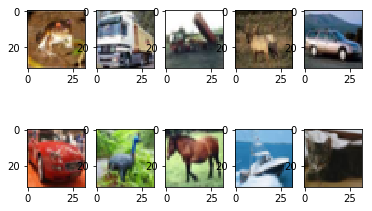

In [0]:
# データセットの画像の確認
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_images[i])
plt.show()

In [0]:
# データセットのラベルの確認
print(train_labels[0:10])

[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]


In [0]:
# データセットの画像の前処理
train_images = train_images.astype('float32')/255.0
test_images = test_images.astype('float32')/255.0

# データセットの画像の前処理後のシェイプの確認
print(train_images.shape)
print(test_images.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [0]:
# データセットのラベルの前処理
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

# データセットのラベルの前処理後のシェイプの確認
print(train_labels.shape)
print(test_labels.shape)

(50000, 10)
(10000, 10)


In [0]:
#モデルの作成
model = Sequential()

# Conv→Conv→Pool→Dropout
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Conv→Conv→Pool→Dropout
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten→Dense→Dropout→Dense
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# TPUモデルへの変換
import tensorflow as tf
import os
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.36.118.234:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 1842085832222270528)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 1690464013070989857)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 15334883173095176971)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:

In [0]:
# コンパイル
tpu_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['acc'])

INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}


In [0]:
# 学習
history = tpu_model.fit(train_images, train_labels, batch_size=128,
    epochs=20, validation_split=0.1)

Train on 50000 samples, validate on 5000 samples
Epoch 1/20
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(16,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(16, 32, 32, 3), dtype=tf.float32, name='conv2d_input_10'), TensorSpec(shape=(16, 10), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for conv2d_input
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7fa73100a6d8> []
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 4.380138635635376 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:CPU -> TPU lr: 

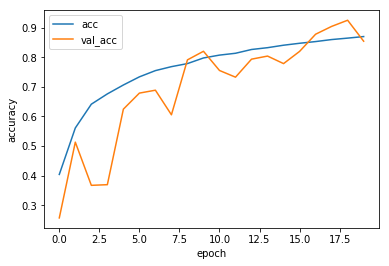

In [0]:
# グラフの表示
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

In [0]:
# 評価
test_loss, test_acc = tpu_model.evaluate(test_images, test_labels)
print('loss: {:.3f}\nacc: {:.3f}'.format(test_loss, test_acc ))

INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(4,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(4, 32, 32, 3), dtype=tf.float32, name='conv2d_input_10'), TensorSpec(shape=(4, 10), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for conv2d_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7fa72d646fd0> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 1.9073982238769531 secs
 9920/10000 [============================>.] - ETA: 0s - loss: 1.0753 - acc: 0.7124INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(2,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(2, 32, 32, 3), dtype=tf.float32, name='conv2d_input_10'), TensorSpec(shape=(2, 10), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default pl

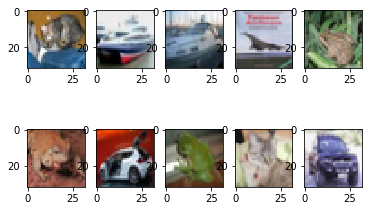

['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile']


In [0]:
# 推論する画像の表示
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(test_images[i])
plt.show()

# 推論したラベルの表示
test_predictions = tpu_model.predict(test_images[0:16]) # 学習データ数を16個に増やす
test_predictions = np.argmax(test_predictions, axis=1)[0:10] # 結果数を10個に減らす
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck']
print([labels[n] for n in test_predictions])